In [1]:
import glob
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification

import matplotlib.pyplot as plt

import numpy as np
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
import torch
from transformers import pipeline


In [2]:
csvs = glob.glob(r"D:\DAC\UOB\*.csv")

In [3]:
df = dd.read_csv(csvs).compute().reset_index(drop=True)

In [4]:
df = df[df['Content'].str.strip() != '']
df.dropna(inplace =True)

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'singapore', 'malaysia' , 'said' ,','])

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    """ function to lemmatize the words"""
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [6]:

def pre_process(dataframe):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Stopwords
        3) Removing single alphabets
        4) Removing WhiteSpace
        5) Removing Punctuations
        6) Removing Emojis & other image related symbolds
        7) Lemmatizing the words

    '''
    
    #converts text to lowercase
    dataframe['Content'] = dataframe['Content'].apply(lambda x: x.lower())

    #Remove all punctuations
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))

    #Remove all stopwords
    dataframe['Content'] = dataframe['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Numbers
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))

    #remove single alphabets
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\b[a-zA-Z]\s', ' ' , x))

    #remove Hyperlinks
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("<.*?>+|https?://\S+|www\.\S+", " " , x))

    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("/^\s+|\s+$|\s+(?=\s)/g", "" , x))


    #Removing Emojis and any other image related symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoji
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    
    #dataframe['Content'] = dataframe['Content'].apply(lambda x: emoji_pattern.sub(r' ', x))

    #Lemmatize the words
    dataframe['Content'] = dataframe['Content'].apply(lemmatize_words) 



In [7]:
pre_process(df)

In [8]:
headlines_array = np.array(df['Content'])
headlines_list = list(headlines_array)

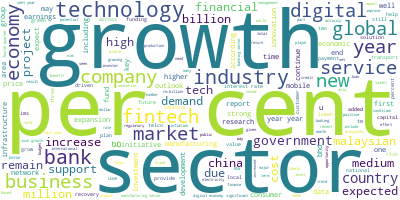

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')

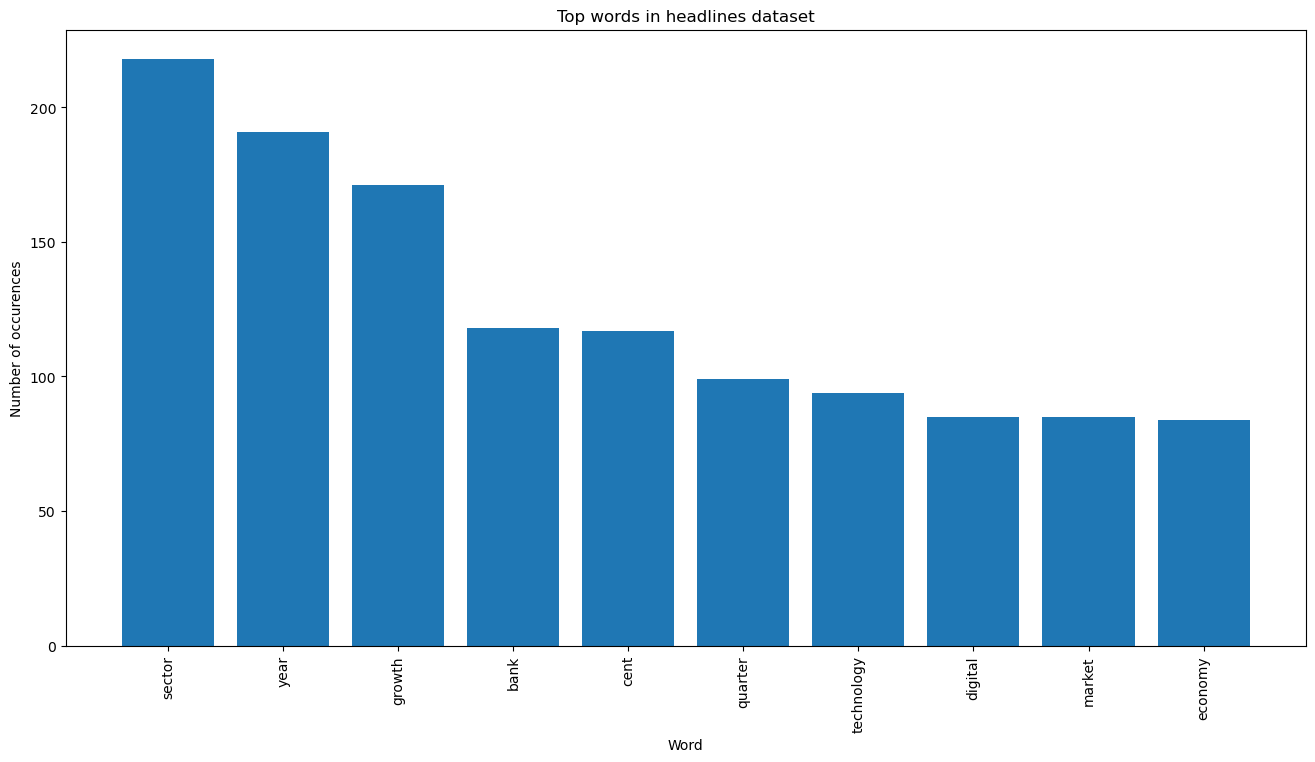

In [12]:
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['Content'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [13]:
def sentiment_dataframe(predictions):
    

    #Headline #Positive #Negative #Neutral
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'Headline':headlines_list,
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral}
        
    dataframe = pd.DataFrame(table)

    return dataframe

In [14]:
def get_sentiments(pretrained_model):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

    inputs = tokenizer(headlines_list, padding = True, truncation = True, return_tensors='pt')
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    dataframe = sentiment_dataframe(predictions)

    return dataframe

In [15]:
finbert_sentiments = get_sentiments("ProsusAI/finbert")
financial_sentiments = get_sentiments("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sigma_sentiments = get_sentiments("Sigma/financial-sentiment-analysis")

In [16]:
def get_sentimentsII(row, pipeline):
  content = row['Content']
  result = pipeline(content)    
  row['sentiment'] = result[0]['label']
  row['sentiment_score'] = result[0]['score']
  
  return row

In [17]:
soleimanian_pipeline = pipeline("sentiment-analysis",model="soleimanian/financial-roberta-large-sentiment", tokenizer="soleimanian/financial-roberta-large-sentiment", max_length=512, truncation=True)
yiyangkhust_pipeline = pipeline("sentiment-analysis",model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone", max_length=512, truncation=True)


In [18]:
soleimanian_sentimens = df.apply(get_sentimentsII, pipeline=soleimanian_pipeline, axis=1)
yiyangkhost_df = df.apply(get_sentimentsII, pipeline=yiyangkhust_pipeline, axis=1)

In [40]:
yiyangkhost_df.head()

,Title,Content,Site-Name,sentiment,sentiment_score
0,Malaysia: A Flourishing Fintech Ecosystem,malaysian embraced financial technology common...,imf,Positive,0.999826
1,Fintech Report 2022: Malaysia Charts a New Pat...,regulator policymakers actively supporting fin...,fintechnews,Positive,0.999999
3,Loan growth to closely track GDP,petaling jaya malaysian banking sector bellwet...,thestar,Positive,0.999998
4,Analysts mixed on banking sector’s valuations ...,kuala lumpur jan investment analyst shared mi...,theedgemalaysia,Positive,1.000000
5,Malaysia central bank maintains 2023 growth fo...,kuala lumpur central bank wednesday mar maint...,channelnewsasia,Positive,0.995942


In [41]:
soleimanian_sentimens.merge(yiyangkhost_df[['Content','sentiment' , 'sentiment_score']], how='outer', on='Content' ,suffixes=(' _soleimanian', '_yiyang,'))

,Title,Content,Site-Name,sentiment _soleimanian,sentiment_score _soleimanian,"sentiment_yiyang,","sentiment_score_yiyang,"
0,MAS Commits Up To S$150 million for Technology...,august monetary authority ma today announced...,mas,positive,0.998092,Positive,0.999975
1,Blueprint to help Malaysia achieve digital eco...,nov technology continues drive advance throu...,mida,positive,0.997550,Positive,0.999930
2,HIGHEST GROWTH IN PROFIT AFTER TAX OVER THREE ...,article first appeared edge weekly november ...,theedgemalaysia,positive,0.997219,Positive,0.999999
3,Singapore banks face challenging outlook as lo...,bank likely face muted result second half hig...,spglobal,negative,0.998082,Positive,0.981034
4,TIPPING POINT FOR MALAYSIA AND TELCO INDUSTRY,beyond promise g bringing faster home broadban...,thestar,positive,0.997783,Positive,0.999999
5,Singapore ICT sector: Driving the Nation’s Eco...,big infocomm technology ict sector one world w...,mycareersfuture,positive,0.998143,Positive,1.000000
6,New S$55m media funding aims to enhance virtua...,channelling fund medium landscape help local c...,channelnewsasia,positive,0.996968,Positive,0.812696
7,Tech sector outlook remains uncertain,click enlarge kuala lumpur significant rebound...,thestar,negative,0.997986,Positive,0.998249
8,Singapore’s digital economy – from e-commerce ...,digital economy contributed gross domestic pr...,cnbc,positive,0.998157,Positive,0.999998
9,Singapore’s economy grew 2.8% in Q4 as manufac...,economy gained momentum fourth quarter amid r...,channelnewsasia,positive,0.997925,Positive,0.999025


In [33]:
soleimanian_sentimens.sentiment.value_counts()

sentiment
positive    24
negative    15
neutral      2
Name: count, dtype: int64

In [20]:
financial_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.000203,0.000281,0.999517
1,regulator policymakers actively supporting fin...,0.000180,0.000152,0.999668
2,petaling jaya malaysian banking sector bellwet...,0.000253,0.000140,0.999607
3,kuala lumpur jan investment analyst shared mi...,0.005176,0.000310,0.994514
4,kuala lumpur central bank wednesday mar maint...,0.001945,0.000141,0.997914


In [21]:
sigma_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.015902,0.095215,0.888882
1,regulator policymakers actively supporting fin...,0.008524,0.040788,0.950688
2,petaling jaya malaysian banking sector bellwet...,0.010910,0.021283,0.967808
3,kuala lumpur jan investment analyst shared mi...,0.167920,0.226958,0.605121
4,kuala lumpur central bank wednesday mar maint...,0.044103,0.068929,0.886967


In [22]:
finbert_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.128801,0.016848,0.854351
1,regulator policymakers actively supporting fin...,0.356630,0.028099,0.615271
2,petaling jaya malaysian banking sector bellwet...,0.185115,0.140288,0.674596
3,kuala lumpur jan investment analyst shared mi...,0.309178,0.048949,0.641873
4,kuala lumpur central bank wednesday mar maint...,0.630031,0.245393,0.124575
